In [68]:
# Required imports

In [69]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
plt.ion()

In [70]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'datasets/Kaggle'
for x in ['train','val']:
    folder = os.path.join(data_dir, x)
    if not os.path.exists(folder):
        raise ValueError(f"Папка {folder} не найдена!")
    classes = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder,d))]
    if len(classes) == 0:
        raise ValueError(f"В папке {folder} нет подпапок с классами!")
    for cls in classes:
        cls_path = os.path.join(folder, cls)
        files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        if len(files) == 0:
            raise ValueError(f"В папке {cls_path} нет изображений!")

# загрузка датасетов
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','val']}

# DataLoader
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

print("Классы:", class_names)
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

Классы: ['paper', 'rock', 'scissors']


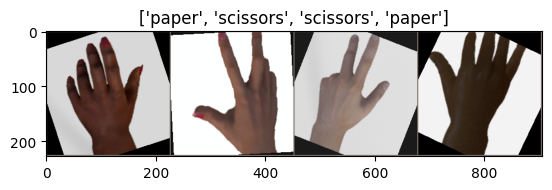

In [71]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# выводим очередную серию изображений
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [72]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, dtype=torch.float32)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [73]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [74]:
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features # model_ft.fc -- это слой Linear
model_ft.fc = nn.Linear(num_ftrs, 3) # подменяем оригинальный слой своим

model_ft = model_ft.to(device, dtype=torch.float32)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Будем уменьшать скорость обучения с коэффициентом 0.1 каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [75]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6896 Acc: 0.7325
val Loss: 0.2210 Acc: 0.8844

Epoch 1/24
----------
train Loss: 0.5936 Acc: 0.7865
val Loss: 0.0851 Acc: 0.9839

Epoch 2/24
----------
train Loss: 0.3860 Acc: 0.8575
val Loss: 0.0259 Acc: 0.9946

Epoch 3/24
----------
train Loss: 0.3816 Acc: 0.8683
val Loss: 0.0364 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.3348 Acc: 0.8790
val Loss: 0.0347 Acc: 0.9946

Epoch 5/24
----------
train Loss: 0.3164 Acc: 0.8849
val Loss: 0.0460 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.2578 Acc: 0.9028
val Loss: 0.0613 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.2252 Acc: 0.9095
val Loss: 0.1012 Acc: 0.9973

Epoch 8/24
----------
train Loss: 0.2239 Acc: 0.9135
val Loss: 0.0559 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.2252 Acc: 0.9127
val Loss: 0.0674 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.2282 Acc: 0.9083
val Loss: 0.0609 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.2157 Acc: 0.9214
val Loss: 0.0788 Acc: 1.0000

Ep

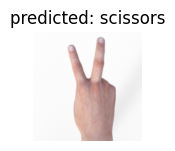

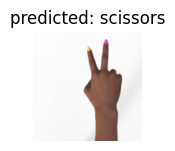

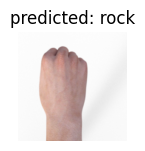

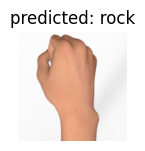

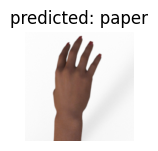

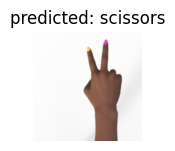

In [83]:
visualize_model(model_ft)

In [80]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [82]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9035 Acc: 0.6048
val Loss: 1.0445 Acc: 0.6532

Epoch 1/24
----------
train Loss: 0.7584 Acc: 0.6877
val Loss: 0.3065 Acc: 0.8817

Epoch 2/24
----------
train Loss: 0.7763 Acc: 0.6937
val Loss: 0.5908 Acc: 0.6935

Epoch 3/24
----------
train Loss: 0.7135 Acc: 0.7147
val Loss: 0.3399 Acc: 0.8495

Epoch 4/24
----------
train Loss: 0.7427 Acc: 0.7063
val Loss: 0.2925 Acc: 0.8710

Epoch 5/24
----------
train Loss: 0.7189 Acc: 0.7206
val Loss: 0.2977 Acc: 0.8495

Epoch 6/24
----------
train Loss: 0.6057 Acc: 0.7579
val Loss: 0.4487 Acc: 0.8038

Epoch 7/24
----------
train Loss: 0.6211 Acc: 0.7409
val Loss: 0.4359 Acc: 0.8118

Epoch 8/24
----------
train Loss: 0.5909 Acc: 0.7615
val Loss: 0.4443 Acc: 0.7984

Epoch 9/24
----------
train Loss: 0.5962 Acc: 0.7516
val Loss: 0.3539 Acc: 0.8441

Epoch 10/24
----------
train Loss: 0.5913 Acc: 0.7587
val Loss: 0.3713 Acc: 0.8199

Epoch 11/24
----------
train Loss: 0.5956 Acc: 0.7536
val Loss: 0.5561 Acc: 0.7715

Ep

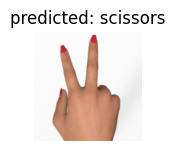

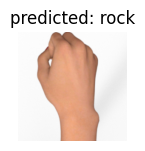

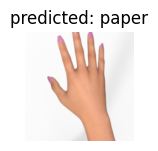

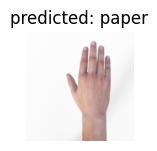

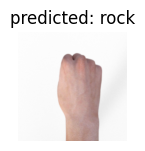

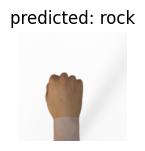

In [86]:
visualize_model(model_conv)

plt.ioff()
plt.show()